# **Working memory training**: Modularity-behaviour analysis 

**Last edited:** 12-20-2019

In [188]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)
library(Hmisc)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

Step 1: Preparing data
-----------------------

In [96]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

#---Modularity
Q <- read.csv('./data/neuroimaging/03-modularity/static/Q_normalized_power_tidy.csv')
Q$Session <- factor(Q$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
Q$Condition <- factor(Q$Condition, levels = c('Rest', '1-back', '2-back'))
Q$Group <- factor(Q$Group, levels = c('Experimental', 'Control'))


Q$Task[Q$Condition == '1-back'] <- 'N-back'
Q$Task[Q$Condition == '2-back'] <- 'N-back'
Q$Task[Q$Condition == 'Rest'] <- 'Rest'

first_session_motion = 'sub-21' # subject with highly motion on first session
dualnback_motion = c('sub-13', 'sub-21', 'sub-23', 'sub-50')

# Selecting 1-back
Q_1back <- Q %>% 
        filter(Condition == '1-back') %>%
        select(-Task) %>% 
        select(-Condition)

colnames(Q_1back)[4] <- 'Q_norm_1back'

# Selecting 2-back
Q_2back <- Q %>% 
           filter(Condition == '2-back') %>% 
           select(-Task) %>% 
           select(-Condition)

colnames(Q_2back)[4] <- 'Q_norm_2back'

# Delta Q
Q_2back_1back <- Q_2back$Q_norm_2back - Q_1back$Q_norm_1back

Q_diff <- Q_1back %>% left_join(Q_2back)
Q_diff$Q_2back_1back <- Q_2back_1back  

head(Q_diff)

Joining, by = c("Subject", "Group", "Session")


Subject,Group,Session,Q_norm_1back,Q_norm_2back,Q_2back_1back
sub-01,Control,Naive,2.116409,2.210752,0.09434333
sub-01,Control,Early,2.313354,2.634171,0.32081705
sub-01,Control,Middle,2.647316,2.142436,-0.50487984
sub-01,Control,Late,3.066959,2.751871,-0.31508854
sub-02,Control,Naive,2.831184,2.535654,-0.29552974
sub-02,Control,Early,3.098727,3.005136,-0.09359070


In [107]:
#--- Behaviour

# Behaviour 1-back
behaviour_1back <- behaviour %>% 
                   filter(Condition=='1-back') %>%
                   select(-Condition)

# Behaviour 2-back
behaviour_2back <- behaviour %>% 
                   filter(Condition=='2-back') %>% 
                   select(-Condition)

# Add 1-back/2-back labels to behaviour columns
colnames(behaviour_1back)[3:5] <- paste(colnames(behaviour_1back)[3:5], "1back", sep = "_")
colnames(behaviour_2back)[3:5] <- paste(colnames(behaviour_2back)[3:5], "2back", sep = "_")

# Calculate change from 1-back to 2-back
behaviour_2back_1back <- behaviour_2back[3:5] - behaviour_1back[3:5]
colnames(behaviour_2back_1back) <- paste(colnames(behaviour)[4:6], "delta", sep = "_")


behaviour_diff <- behaviour_1back %>% 
    left_join(behaviour_2back, by=c("Subject", "Session", "Group")) %>% 
    cbind(delta)

#--- Merging modulatiy and behaviour into one table

Q_beh <- left_join(Q_diff, behaviour_diff)
head(Q_beh)

Joining, by = c("Subject", "Group", "Session")
Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”Warning message:
“Column `Session` joining factors with different levels, coercing to character vector”

Subject,Group,Session,Q_norm_1back,Q_norm_2back,Q_2back_1back,Accuracy_1back,pRT_1back,Dprime_1back,Accuracy_2back,pRT_2back,Dprime_2back,Accuracy_delta,pRT_delta,Dprime_delta
sub-01,Control,Naive,2.116409,2.210752,0.09434333,0.8666667,1001.0327,3.437119,0.7833333,1433.765,2.514055,-0.08333333,432.73223,-0.9230648
sub-01,Control,Early,2.313354,2.634171,0.32081705,0.8666667,1003.1715,3.429125,0.8666667,1282.489,3.117902,0.00000000,279.31739,-0.3112230
sub-01,Control,Middle,2.647316,2.142436,-0.50487984,0.8000000,1178.2379,2.758558,0.9000000,1108.405,3.460899,0.10000000,-69.83277,0.7023419
sub-01,Control,Late,3.066959,2.751871,-0.31508854,0.8166667,1181.4785,2.720889,0.8166667,1216.572,2.946157,0.00000000,35.09329,0.2252675
sub-02,Control,Naive,2.831184,2.535654,-0.29552974,0.9666667,1135.0613,3.843789,0.6500000,1289.423,2.348657,-0.31666667,154.36136,-1.4951323
sub-02,Control,Early,3.098727,3.005136,-0.09359070,0.9500000,957.6361,3.972061,0.9166667,1032.879,3.539530,-0.03333333,75.24335,-0.4325309


Step 2: Correlation of delta modularity and delta pRT (first session)
-----------------------

In [111]:
naive_diff <- Q_beh %>% filter(Session == 'Naive') %>% filter(Subject != 'sub-21') 
cor.test(naive_diff$Q_2back_1back, naive_diff$pRT_delta)
cor.test(naive_diff$Q_2back_1back, naive_diff$Dprime_delta)


	Pearson's product-moment correlation

data:  naive_diff$Q_2back_1back and naive_diff$pRT_delta
t = -1.7454, df = 43, p-value = 0.08806
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5120875  0.0392826
sample estimates:
       cor 
-0.2572172 



	Pearson's product-moment correlation

data:  naive_diff$Q_2back_1back and naive_diff$Dprime_delta
t = 0.77226, df = 43, p-value = 0.4442
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1828512  0.3968690
sample estimates:
      cor 
0.1169604 


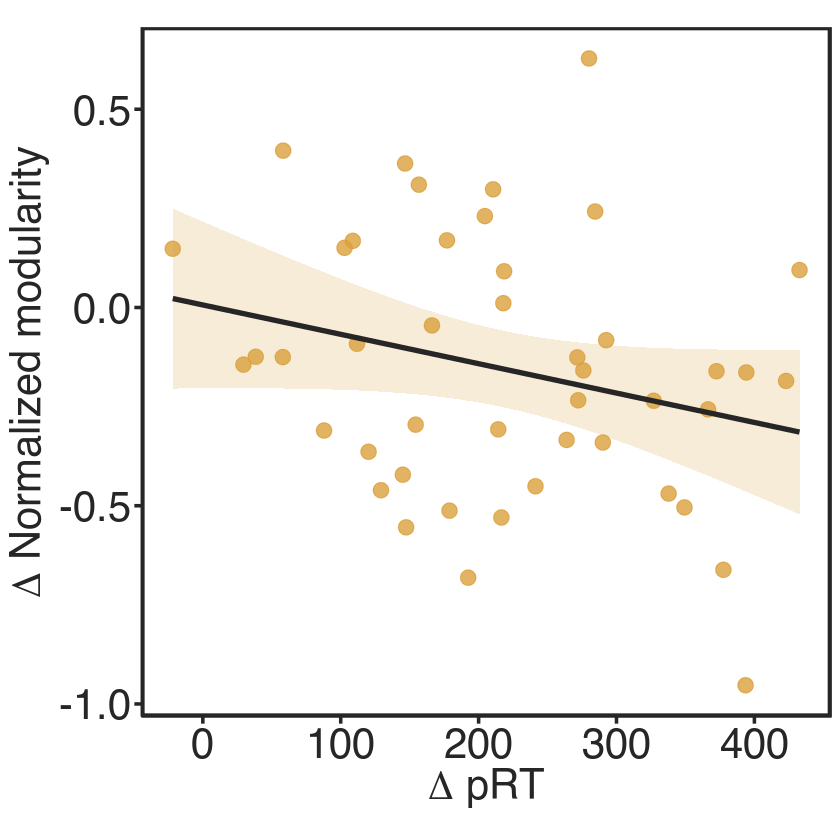

In [102]:
p <- ggplot(naive, aes(y = Q_2back_1back, x = naive$pRT_delta)) + 
    geom_point(col = '#daa03d',size = 4, alpha = 0.8) + 
    geom_smooth(
            method = 'lm', 
            col = '#262626ff', fill = '#daa03d', size = 1.5, alpha = 0.2) +
    theme_training + 
    xlab(expression(paste(Delta, ' pRT'))) + 
    ylab(expression(paste(Delta, ' Normalized modularity')))
p

#ggsave("figures/Figure_modu_pRT_naive_corr.pdf", plot = p, width = 8, height = 6, dpi = 300)  

Step 3: Correlation of delta modularity and delta pRT change
-----------------------

In [186]:
#--- Preparing data
Q_beh <- Q_beh %>% 
               filter(!(Subject %in% dualnback_motion))

naive <- Q_beh %>% 
        filter(Session %in% c('Naive')) %>%
        select(-Session)

late <- Q_beh %>% 
        filter(Session %in% c('Late')) %>%
        select(-Session)

# Add naive/late labels to columns
colnames(naive)[3:14] <- paste(colnames(naive)[3:14], "naive", sep = "_")
colnames(late)[3:14] <- paste(colnames(late)[3:14], "late", sep = "_")

# Calculate change from Naive to Late
Q_beh_change <- late[3:14] - naive[3:14]
colnames(Q_beh_change) <- paste(colnames(Q_beh%>%select(-Session))[3:14], "change", sep = "_")

Q_beh_diff <- left_join(naive, late) %>% cbind(Q_beh_change)
Q_beh_diff_exp <- Q_beh_diff %>% filter(Group=='Experimental')

Joining, by = c("Subject", "Group")


In [178]:
# 2-back pRT change vs. 2-back Q change:
cor.test(Q_beh_diff$pRT_2back_change, Q_beh_diff$Q_norm_2back_change) # all
cor.test(Q_beh_diff_exp$pRT_2back_change, Q_beh_diff_exp$Q_norm_2back_change) # experimental


	Pearson's product-moment correlation

data:  Q_beh_diff$pRT_2back_change and Q_beh_diff$Q_norm_2back_change
t = 0.58919, df = 40, p-value = 0.559
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2172997  0.3858123
sample estimates:
       cor 
0.09275774 



	Pearson's product-moment correlation

data:  Q_beh_diff_exp$pRT_2back_change and Q_beh_diff_exp$Q_norm_2back_change
t = 1.1789, df = 19, p-value = 0.253
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1922729  0.6226000
sample estimates:
      cor 
0.2610843 


In [175]:
# Delta pRT change vs. Delta Q change:
cor.test(Q_beh_diff$pRT_delta_change, Q_beh_diff$Q_2back_1back_change) # all
cor.test(Q_beh_diff_exp$pRT_delta_change, Q_beh_diff_exp$Q_2back_1back_change) # experimental


	Pearson's product-moment correlation

data:  Q_beh_diff$pRT_delta_change and Q_beh_diff$Q_2back_1back_change
t = 0.68173, df = 40, p-value = 0.4993
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2033856  0.3981337
sample estimates:
      cor 
0.1071706 



	Pearson's product-moment correlation

data:  Q_beh_diff_exp$pRT_delta_change and Q_beh_diff_exp$Q_2back_1back_change
t = -0.63696, df = 19, p-value = 0.5318
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5424217  0.3062077
sample estimates:
       cor 
-0.1445921 


Step 4: Correlation of delta modularity and maximum n-level during training
-----------------------

In [187]:
training_progress <- read.csv('data/behavioral/WM_training_max_level.csv')
beh_train_perf_diff <- left_join(Q_beh_diff_exp, training_progress)

cor.test(beh_train_perf_diff$Q_norm_2back_change, beh_train_perf_diff$Max_n_lev)

Joining, by = "Subject"
Warning message:
“Column `Subject` joining factors with different levels, coercing to character vector”


	Pearson's product-moment correlation

data:  beh_train_perf_diff$Q_norm_2back_change and beh_train_perf_diff$Max_n_lev
t = 0.34882, df = 19, p-value = 0.7311
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3644685  0.4944298
sample estimates:
       cor 
0.07976875 
